In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from google.colab import drive
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset =pd.read_csv("/content/drive/My Drive/spam.csv", encoding='latin-1')

In [ ]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#removing unnamed columns
dataset = dataset.drop('Unnamed: 2', 1)
dataset = dataset.drop('Unnamed: 3', 1)
dataset = dataset.drop('Unnamed: 4', 1)
dataset.head()


In [ ]:
dataset = dataset.rename(columns = {'v1':'label','v2':'message'})

In [ ]:
dataset.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
dataset.head(4)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...


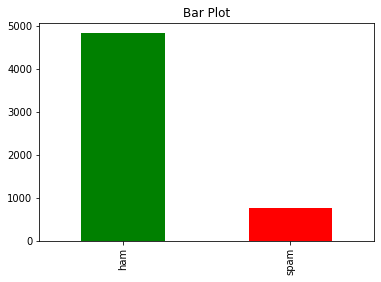

In [ ]:
count_Class=pd.value_counts(dataset["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show();

In [ ]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(dataset["message"])
np.shape(X)

(5572, 8404)

In [ ]:
# Classifying spam and not spam msgs as 1 and 0

dataset["label"]=dataset["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, dataset['label'], test_size=0.70, random_state=42)

list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

rf = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rf_model = rf.fit(X_train,y_train)

y_pred=rf_model.predict(X_test)
precision,recall,fscore,support =score(y_test,y_pred,pos_label=1, average ='binary')
print('Precision : {} / Recall : {} / fscore : {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))


Precision : 0.987 / Recall : 0.724 / fscore : 0.835 / Accuracy: 0.962


In [ ]:
!pip install keras.utils

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

vocab_size = 400
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 16
encode = ({'ham': 0, 'spam': 1} )
#new dataset with replaced values
dataset = dataset.replace(encode)

X = dataset['message']
Y = dataset['label']
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

X = np.array(X)
y = np.array(Y)

X = pad_sequences(X, maxlen=max_length)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.20, random_state=7)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test,y_test), verbose=2)

results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]


print(f"[+] Accuracy: {accuracy*100:.2f}%")

from keras.preprocessing import sequence

#Defining the function
def get_predictions(txts):
    txts = tokenizer.texts_to_sequences(txts)
    txts = sequence.pad_sequences(txts, maxlen=max_length)
    preds = model.predict(txts)
    if(preds[0] > 0.5):
        print("SPAM MESSAGE")
        
    else:
        print('NOT SPAM')

txts=["You have won a free ticket to las vegas. Contact now"]

get_predictions(txts)

txts=["Hey there call me asap!!"]

get_predictions(txts)

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=078b82d6656ab089f2f8c267716c9e4d2a3fe8e235b72ff99e3b395b8a517fcc
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           6400      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
140/140 - 2s - loss: 0.5704 - accuracy: 0.8434 - val_loss: 0.4006 - val_accuracy: 0.8700 - 2s/epoch - 14ms/st